In [1]:
# default_exp models

# Import

In [2]:
#export
import torchvision.models
from fastai.callbacks import *
from fastai.vision import *

from deoldify.data import *

# Config

In [3]:
#export
dir_data = Path('/home/blaberj/justinblaber/deoldify/data')
dir_imgs = dir_data/'imgs'
dir_colr = dir_imgs/'colr'
dir_gray = dir_imgs/'gray'

# Utility

In [4]:
#export
def img2tensor(img, normalize=True, cuda=True, batchify=True):
    img = F.to_tensor(img)
    if normalize: img = F.normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    if cuda:      img = img.cuda()
    if batchify:  img = img[None]  
    return img

In [5]:
#export
def leaf_modules(model): # TODO: does pytorch have a built-in for this?
    for m in model.modules():
        if len(list(m.children())) == 0:
            yield m

In [6]:
#export
def gram_matrix(x):
    n,c,h,w = x.shape
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

# Feature loss

In [7]:
#export
class FeatureLoss():
    def __init__(self, encoder, sz, idx_styl, idx_cont, w_styl, w_cont, w_colr, w_gray):
        # Set up encoder
        encoder = encoder.cuda()
        encoder.eval()
        for p in encoder.parameters(): p.requires_grad = False
        self.encoder = encoder

        # Use hooks + dummy pass to get feature modules (modules right before size change)
        def _hook(module, x, y): 
            if x[0].shape[2:] != y.shape[2:]:
                module.size_changed = True                
        hooks = [m.register_forward_hook(_hook) for m in leaf_modules(encoder)]
        encoder(torch.zeros(1, 3, sz, sz, device='cuda'))        
        m_feats, m_prev = [], None
        for m in leaf_modules(encoder):
            if hasattr(m, 'size_changed'): m_feats.append(m_prev)
            m_prev = m
        for h in hooks: h.remove()
        self.m_feats = m_feats

        # Hook modules for style and content loss
        def _hook(module, x, y): module.x = x[0]
        self.hooks = [self.m_feats[idx].register_forward_hook(_hook) for idx in set(idx_styl+idx_cont)]
        self.idx_styl, self.idx_cont = idx_styl, idx_cont
                                    
        # Store weights
        self.w_styl, self.w_cont, self.w_colr, self.w_gray = w_styl, w_cont, w_colr, w_gray
        
    def _get_styl_feats(self): return [self.m_feats[idx].x for idx in self.idx_styl]

    def _get_cont_feats(self): return [self.m_feats[idx].x for idx in self.idx_cont]

    def __call__(self, y_hat, y):        
        # y is GT color image
        self.encoder(y)
        feats_ts = self._get_styl_feats()
        feats_tc = self._get_cont_feats()

        # y_hat is estimated color image
        self.encoder(y_hat)
        feats_hs = self._get_styl_feats()
        feats_hc = self._get_cont_feats()
        
        # Get losses
        loss = nn.functional.l1_loss        
        ls_s = [self.w_styl[idx]*loss(gram_matrix(feat_ts), gram_matrix(feat_hs)) 
                for idx, (feat_ts, feat_hs) in enumerate(zip(feats_ts, feats_hs))]
        ls_c = [self.w_cont[idx]*loss(feat_tc, feat_hc) 
                for idx, (feat_tc, feat_hc) in enumerate(zip(feats_tc, feats_hc))]
        l_c = self.w_colr*loss(y, y_hat)
        l_g = self.w_gray*loss(rgb2gray(denorm(y)), rgb2gray(denorm(y_hat)))
        l = sum(ls_s) + sum(ls_c) + l_c + l_g
        
        # Metrics
        metrics = {}
        for name_metric in self.metric_names: 
            metrics[name_metric] = eval(name_metric)
        self.metrics = metrics
            
        return l
    
    @property
    def metric_names(self):
        return ['l', 'l_c', 'l_g'] + \
               [f'ls_s[{i}]' for i in range(len(self.idx_styl))] + \
               [f'ls_c[{i}]' for i in range(len(self.idx_cont))]
    
    def __del__(self): 
        for h in self.hooks: 
            h.remove()

# Callbacks

In [8]:
#export
class DisplayResultsCallback(LearnerCallback):
    def __init__(self, learn:Learner, file_img):
        super().__init__(learn)
        self.img_colr = open_image(file_img, convert_mode='RGB')
        self.img_gray = open_image(file_img, convert_mode='L')

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        plt.ion()
        fig, axs = plt.subplots(1, 3, num=epoch, figsize=(12, 3))
        fig.suptitle(f'Epoch: {epoch}')
        self.img_colr.show(axs[0])
        self.img_gray.show(axs[1], cmap='gray')
        self.learn.predict(self.img_gray)[0].show(axs[2])
        fig.canvas.draw()
        plt.pause(.1)
        plt.ioff()

# Test

In [9]:
loss = FeatureLoss(encoder=torchvision.models.vgg16(pretrained=True).features,
                   sz=224, # Size is used to find layers which change size, so keep this constant
                   idx_styl=[0,1,2,3,4],
                   idx_cont=[0,1,2,3,4],
                   w_styl=[1e4,1e4,1e4,1e4,1e4],
                   w_cont=[1, 1, 1, 1, 1],
                   w_colr=1,
                   w_gray=1e2)

In [10]:
src = get_src(100)

In [11]:
data = get_data(src,
                batch_size=16,
                sz=56)

In [12]:
learn = unet_learner(data,
                     models.resnet34,
                     loss_func=loss, 
                     callback_fns=LossMetrics,
                     blur=True,
                     norm_type=NormType.Weight,
                     model_dir='/tmp')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


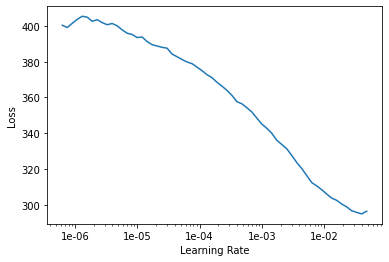

In [13]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,l,l_c,l_g,ls_s[0],ls_s[1],ls_s[2],ls_s[3],ls_s[4],ls_c[0],ls_c[1],ls_c[2],ls_c[3],ls_c[4],time
0,407.704071,419.017731,419.017731,0.672729,12.589012,93.637405,131.412506,150.021378,23.655546,2.055300,0.662606,1.265138,1.780064,0.974969,0.291079,00:01
1,351.276184,338.877319,338.877319,0.427256,5.683758,72.834061,107.230553,124.527847,21.884672,1.921854,0.545985,1.112050,1.590622,0.864177,0.254532,00:00
2,318.881042,314.394073,314.394073,0.368568,4.063646,61.898254,98.822998,120.553307,22.239626,2.017698,0.533790,1.121638,1.623436,0.885543,0.265568,00:00


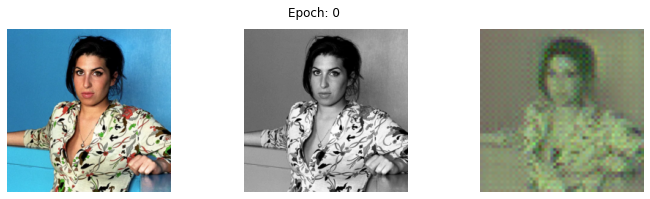

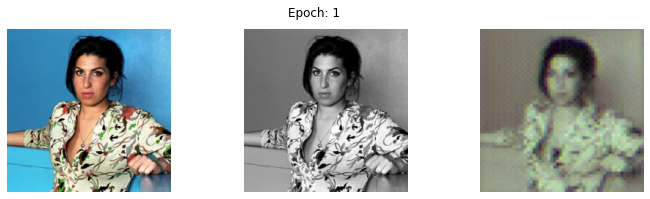

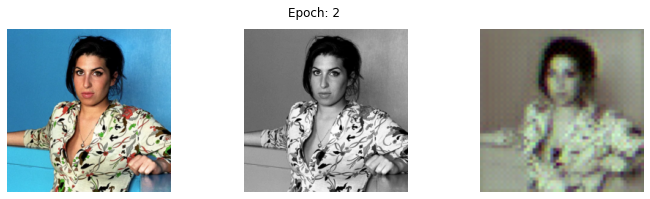

In [14]:
learn.fit_one_cycle(3, 1e-3, callbacks=[DisplayResultsCallback(learn, dir_data/'winehouse.png')])

# Build

In [15]:
!nbdev_build_lib

Converted data.ipynb.
Converted format_images.ipynb.
Converted models.ipynb.
